# Try to use optimal transport with different number of samples between target and source

In [1]:
import moscot.plotting as mtp
from moscot import datasets
from moscot.problems.cross_modality import TranslationProblem

import numpy as np
import pandas as pd
import scipy
from sklearn import preprocessing as pp

import matplotlib.pyplot as plt

import anndata as ad
import scanpy as sc

# My own packages
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from plotnine import *
import seaborn as sns
import os
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

KeyboardInterrupt: 

In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# os.environ["JAX_PLATFORMS"]="cpu"
import jax
jax.devices()

In [3]:
out_path = "/p/project1/hai_fzj_bda/koenig8/ot/data/translation1"
adata_histo = ad.io.read_h5ad(os.path.join(out_path, "adata_histo.h5ad"))
adata_st = ad.io.read_h5ad(os.path.join(out_path, "adata_st.h5ad"))

#### Take a slice around the x coordinate. Since histo has generally more data and encompasses both hemispheres, this will make the problem unbalanced

(2068, 50) (6318, 1536)


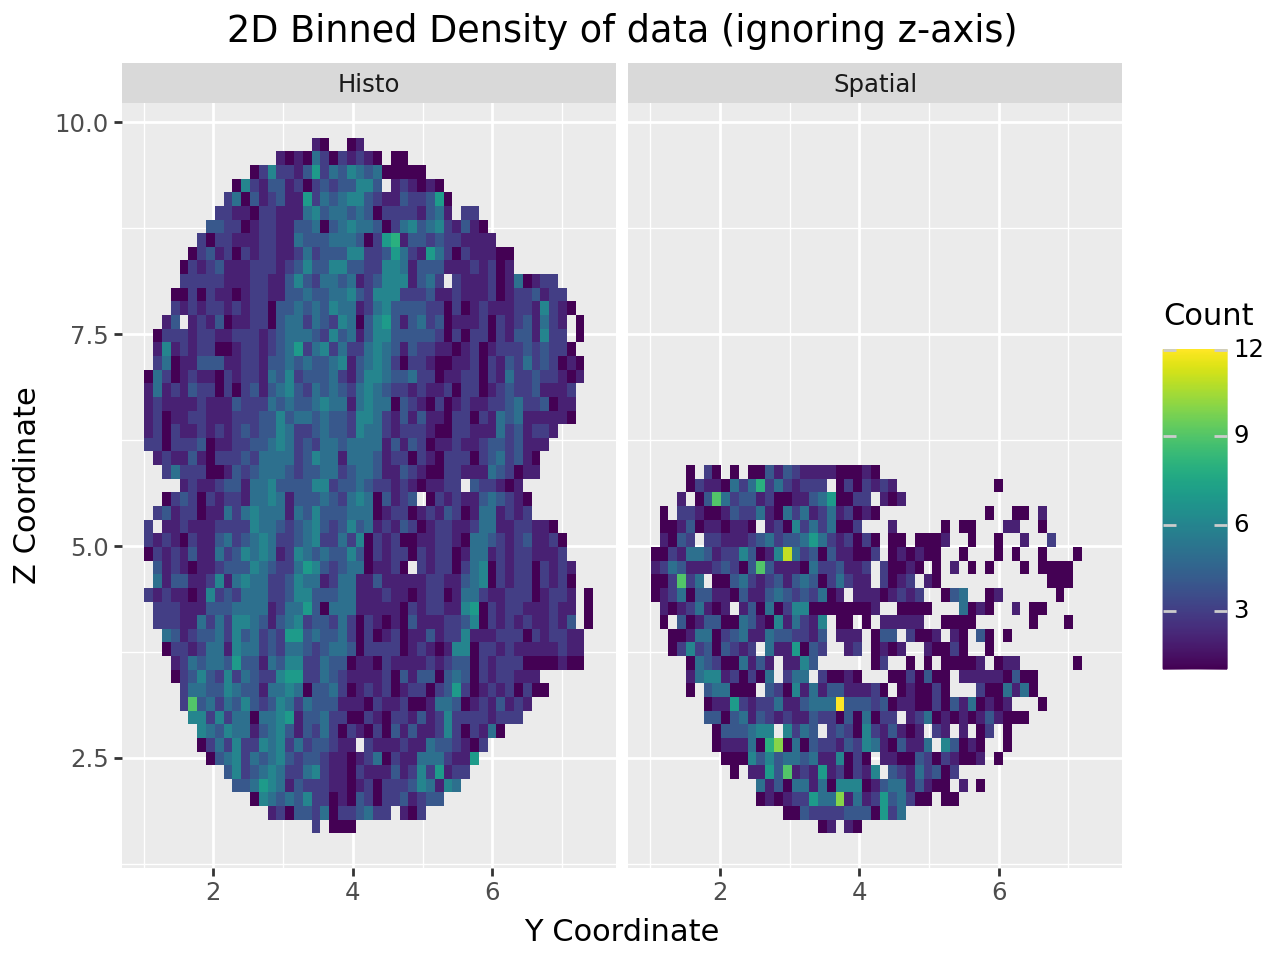

In [4]:
ad_histo = adata_histo[np.abs(adata_histo.obs.x_st - 4) <= 0.2]
ad_st = adata_st[np.abs(adata_st.obs.x_st - 4) <= 0.2]

print(ad_st.shape, ad_histo.shape)

N = 190659
df1 = ad_histo.obs.loc[:, ("y_st", "z_st")].rename(columns=lambda col: col.split("_")[0])
df1["Dataset"] = "Histo"
df2 = ad_st.obs.loc[:, ("y_st", "z_st")].rename(columns=lambda col: col.split("_")[0])
df2["Dataset"] = "Spatial"

# Create a DataFrame
df = pd.concat([df2, df1], ignore_index = True)

plot = (
    ggplot(df, aes(x="y", y="z")) +
    stat_bin2d(bins=50) +  # Adjust bins for resolution
    scale_fill_cmap() +  # Use a perceptually uniform color scale
    facet_wrap("~Dataset") +
    labs(title="2D Binned Density of data (ignoring z-axis)",
         x="Y Coordinate",
         y="Z Coordinate",
         fill="Count")  # Color represents density
)

# Show plot
plot

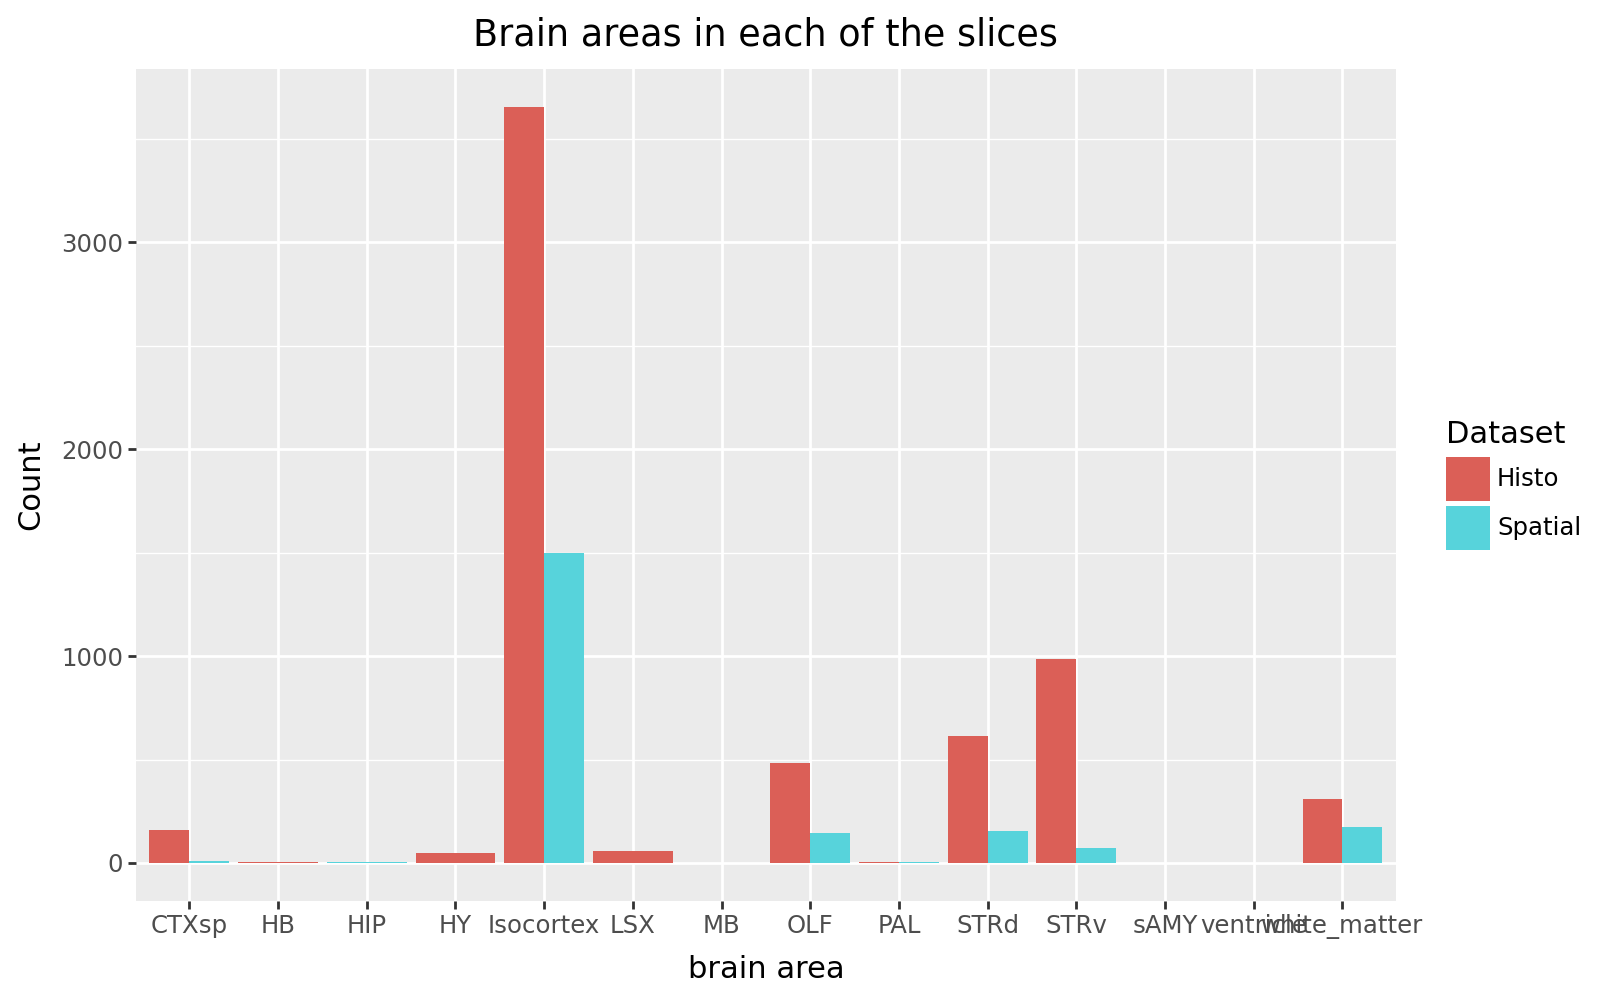

In [5]:
df1 = ad_histo.obs.loc[:, ("brain_area",)]
df1["Dataset"] = "Histo"
df2 = ad_st.obs.loc[:, ("brain_area",)]
df2["Dataset"] = "Spatial"

# Create a DataFrame
df = pd.concat([df2, df1], ignore_index = True)

plot = (
    ggplot(df, aes(x='brain_area', fill='Dataset')) +
    geom_bar(position='dodge') +  # Dodge separates bars for each group
    labs(title="Brain areas in each of the slices", x="brain area", y="Count") +
    theme(figure_size=(8,5))
)
plot

==> The brain areas mostly are the same, just underrepresented for spatial

## Helper functions

In [6]:
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

In [ ]:
def translation_metric(
    translation, source_features, target_features, target_ad, k = 1, emb_key = "uni_embedding", rank = True
):
    # calculate the k nearest neighbors on the translation
    target_embedding = target_ad.obsm[emb_key]
    source_features = np.array(source_features)
    target_features = np.array(target_features)
    N = source_features.shape[0]
    M = target_features.shape[0]
    
    if k == "all" or k == M:
        # Use cdist for comprehensive but slow neighbor calculation
        k = M
        distance_matrix = cdist(translation, target_embedding, metric='euclidean')

        # Get indices of nearest neighbors sorted by distance
        indices = np.argsort(distance_matrix, axis=1)
        distances = np.sort(distance_matrix, axis=1)
    else:
        # Use knn for faster computation
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(target_embedding)
    
        # Find top-k neighbors in target for each src sample
        distances, indices = nbrs.kneighbors(translation)

    # Calculate the MSE weighted by distance/rank of distance
    if rank:
        # Do not use aczual distances, just weight by rank
        distances = np.tile(np.arange(1, k + 1), (N, 1))
        # Add pseudocount to distances to avoid zero division, and turn into weights by taking inverse
        distances = 1/distances 
    else:
        distances = 1/(distances + 1e-8)

    big_translation = np.repeat(source_features[:, np.newaxis, :], k, axis=1)  # Make array to calculate error
    big_nbrs = target_features[indices]

    idwe = np.sum(np.sum(np.square(big_translation - big_nbrs), axis = 2) * distances, axis = 1)
    idwe = idwe / np.sum(distances, axis = 1)  # Normalize by weights

    # Compare to random by dividing by random distances
    rng = np.random.default_rng()
    perm = rng.choice(M, size = (N, k), replace = True)
    random_nbrs = target_features[perm]
    random_idwe = np.sum(np.sum(np.square(big_translation - random_nbrs), axis = 2) * distances, axis = 1)
    random_idwe = random_idwe / np.sum(distances, axis = 1)  # Normalize by weights

    idwe = 1 - np.mean(idwe) / np.mean(random_idwe)
    
    return float(np.mean(idwe))

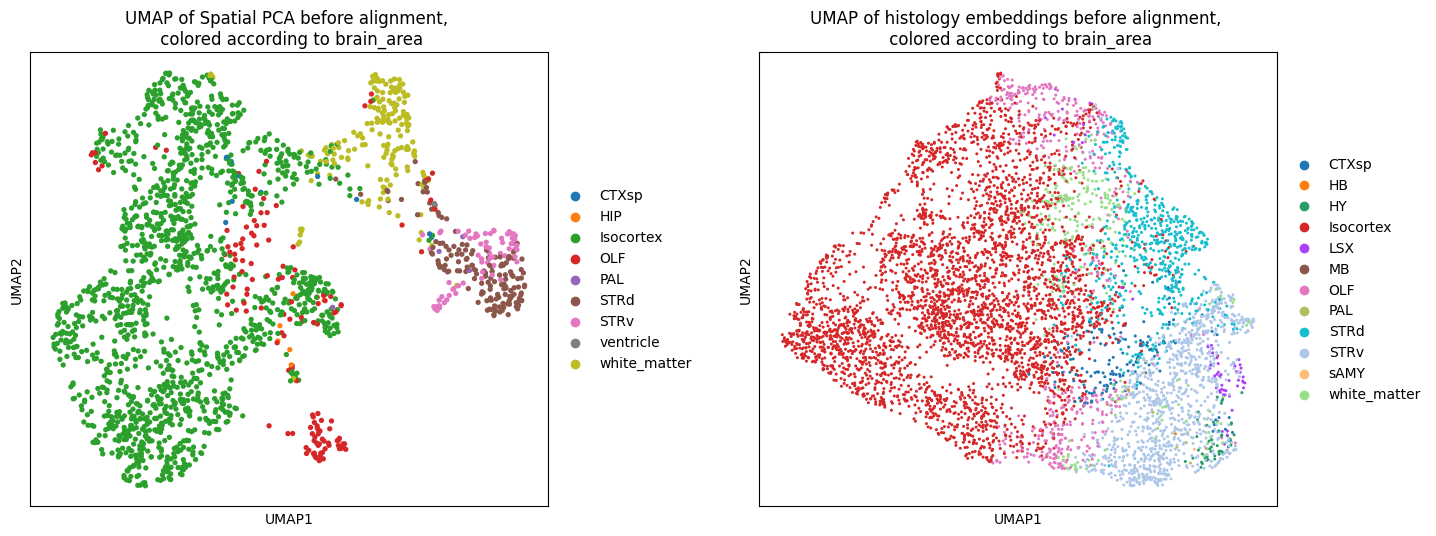

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sc.pp.neighbors(ad_st, n_neighbors=20, random_state=42)
sc.tl.umap(ad_st)
sc.pl.umap(ad_st, color="brain_area", ax=ax1, show=False)
ax1.set_title(
     "UMAP of Spatial PCA before alignment, \n colored according to brain_area"
)

sc.pp.neighbors(ad_histo, n_neighbors=20, random_state=42)
sc.tl.umap(ad_histo)
sc.pl.umap(ad_histo, color="brain_area", ax=ax2, show=False)
ax2.set_title(
    "UMAP of histology embeddings before alignment, \n colored according to brain_area"
)

plt.tight_layout(pad=3.0)
plt.show()

In [9]:
tp = TranslationProblem(adata_src=ad_st, adata_tgt=ad_histo)
tp = tp.prepare(src_attr="pca_embedding", tgt_attr="uni_embedding")

In [10]:
tp = tp.solve(alpha=1.0, epsilon=1e-3)
tp.save("/p/project1/hai_fzj_bda/koenig8/ot/models/unbalanced_translation.pkl", overwrite = True)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(2068, 6318)].                                          
WARNING  Solver did not converge                                                                                   


In [11]:
ad_histo.write_h5ad(os.path.join(out_path, "adata_histo_unbalanced.h5ad"))
ad_st.write_h5ad(os.path.join(out_path, "adata_st_unbalanced.h5ad"))

## Translate on CPU
```
tp2 = TranslationProblem(adata_src=unbalanced_st, adata_tgt=unbalanced_histo)
tp2 = tp2.prepare(src_attr="pca_embedding", tgt_attr="uni_embedding")
tp2 = tp2.load(os.path.join(problems_path, "unbalanced_translation.pkl"))
translated = tp2.translate(source="src", target="tgt", forward=True)
np.save(os.path.join(out_path, "translated_unbalanced.npy"), translated)
```

In [12]:
translated = np.load(os.path.join(out_path, "translated_unbalanced.npy"))
translated.shape

(2068, 1536)

##  Unbalanced translation problem
This does work, the translation retains the shape of the input modality (here 2068). but the solver did not converge, so the overall performance might be bad

# FOSCTTM does not work for two different sample sizes

In [36]:
idwe = translation_metric(
    translated,
    ad_st.obs.loc[:, ["x_st", "y_st", "z_st"]],
    ad_histo.obs.loc[:, ["x_st", "y_st", "z_st"]], 
    ad_histo
)
idwe

10.224452899658024
13.142825964577279


0.2220506512666981

In [41]:
idwe = translation_metric(
    translated,
    ad_st.obsm['brain_area_onehot'].toarray(),
    ad_histo.obsm['brain_area_onehot'].toarray(), 
    ad_histo
)
idwe

0.8849129593810445
1.125725338491296


0.2139175257731959

==> We do improve on random, but not by much

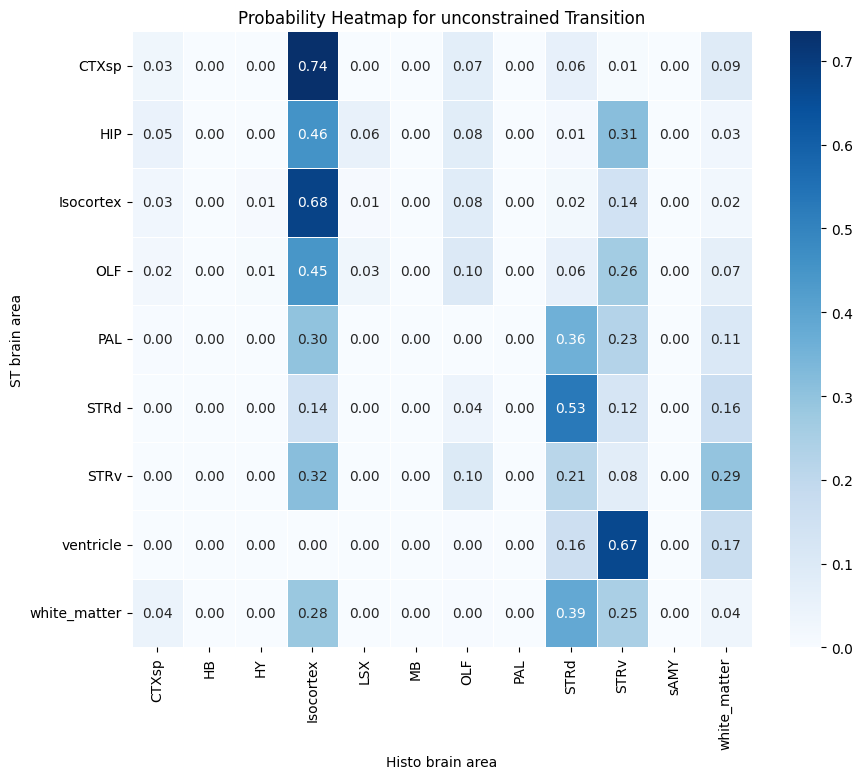

In [42]:
source_order = ad_st.obs["brain_area"].cat.categories
target_order = ad_histo.obs["brain_area"].cat.categories


cell_transition = tp.cell_transition(
    source="src",
    target="tgt",
    source_groups={"brain_area": source_order},
    target_groups={"brain_area": target_order},
    forward=True
)

plt.figure(figsize=(10, 8))
sns.heatmap(cell_transition, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)

# Add labels
plt.ylabel("ST brain area")
plt.xlabel("Histo brain area")
plt.title("Probability Heatmap for unconstrained Transition")

# Show the plot
plt.show()